In [2]:
# base
import numpy as np
import pkg_resources
from sklearn.impute import SimpleImputer
from pandas_plink import read_plink

# viz
import matplotlib.pyplot as plt
from matplotlib import gridspec
import cartopy.crs as ccrs

# feems
from feems.utils import prepare_graph_inputs
from feems import SpatialGraph, Viz
from feems.cross_validation import run_cv

# change matplotlib fonts
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.sans-serif"] = "Arial"

In [3]:
data_path = pkg_resources.resource_filename("feems", "data/")

# read the genotype data and mean impute missing data
(bim, fam, G) = read_plink("{}/wolvesadmix".format(data_path))
imp = SimpleImputer(missing_values=np.nan, strategy="mean")
genotypes = imp.fit_transform((np.array(G)).T)

# setup graph
coord = np.loadtxt("{}/wolvesadmix.coord".format(data_path))  # sample coordinates
outer = np.loadtxt("{}/wolvesadmix.outer".format(data_path))  # outer coordinates
grid_path = "{}/grid_100.shp".format(data_path)  # path to discrete global grid

# graph input files
outer, edges, grid, _ = prepare_graph_inputs(coord=coord, 
                                             ggrid=grid_path,
                                             translated=True, 
                                             buffer=0,
                                             outer=outer)

# construct spatial graph object
sp_graph = SpatialGraph(genotypes, coord, grid, edges, scale_snps=True)

Mapping files: 100%|██████████| 3/3 [00:00<00:00, 27.89it/s]


In [4]:
%%time
# define grids
# reverse the order of lambdas and alphas for warmstart
lamb_grid = np.geomspace(1e-6, 1e2, 20)[::-1]

# run cross-validation
cv_err = run_cv(sp_graph, lamb_grid, n_folds=5, factr=1e10)

# average over folds
mean_cv_err = np.mean(cv_err, axis=0)

# argmin of cv error
lamb_cv = float(lamb_grid[np.argmin(mean_cv_err)])

constant-w/variance fit, converged in 132 iterations, train_loss=2795677.6543430

 fold= 0
iteration lambda=20/20 alpha=1/1
 fold= 1
iteration lambda=20/20 alpha=1/1
 fold= 2
iteration lambda=20/20 alpha=1/1
 fold= 3
iteration lambda=20/20 alpha=1/1
 fold= 4
iteration lambda=20/20 alpha=1/1CPU times: user 37.9 s, sys: 1.47 s, total: 39.4 s
Wall time: 39.7 s


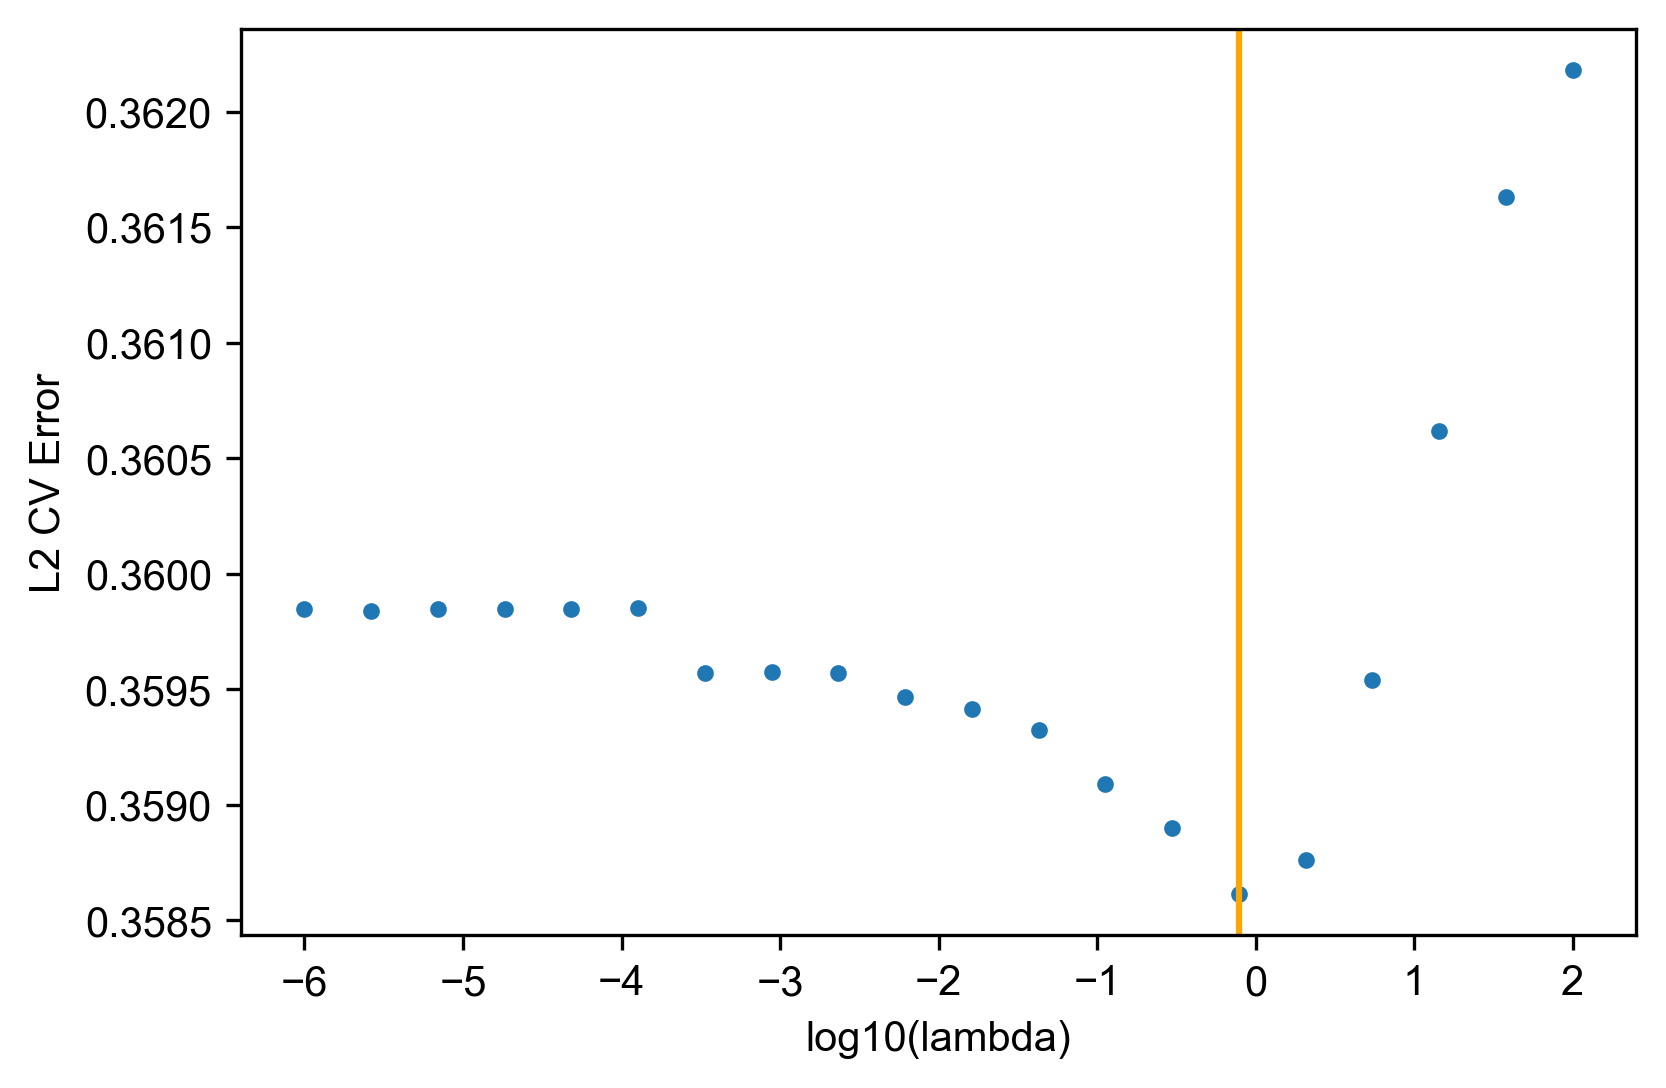

In [5]:
fig, ax = plt.subplots(dpi=300)
ax.plot(np.log10(lamb_grid), mean_cv_err, ".");
ax.set_xlabel("log10(lambda)");
ax.set_ylabel("L2 CV Error");
ax.axvline(np.log10(lamb_cv), color = "orange")

In [8]:
%%time
# figure params
projection = ccrs.EquidistantConic(central_longitude=-108.842926, central_latitude=66.037547)
title_loc = "left"
title_pad = "-10"
title_fontsize = 12
edge_width = .2
edge_alpha = 1
edge_zorder = 3
obs_node_size = 3
obs_node_linewidth = .4
cbar_font_size = 8
cbar_ticklabelsize = 8
cbar_orientation = "horizontal"

# figure setup
fig = plt.figure(dpi=300)
spec = gridspec.GridSpec(ncols=2, nrows=2, figure=fig, wspace=0.0, hspace=0.0)

# axis 00 
ax_00 = fig.add_subplot(spec[0, 0], projection=projection)
ax_00.set_title("A", loc=title_loc, pad=title_pad, fontdict={"fontsize": title_fontsize})
sp_graph.fit(float(lamb_grid[0]))
v = Viz(ax_00, sp_graph, projection=projection, edge_width=edge_width, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
        obs_node_size=obs_node_size, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_map()
v.draw_edges(use_weights=True)
v.draw_obs_nodes(use_ids=False) 
ax_00.text(.2, .85, "lambda={:.5f}\ncv l2 error={:.5f}".format(lamb_grid[0], mean_cv_err[0, 0]), 
           fontdict={"fontsize": 4}, transform = ax_00.transAxes)

# axis 10
ax_10 = fig.add_subplot(spec[1, 0], projection=projection)
ax_10.set_title("B", loc=title_loc, pad=title_pad, fontdict={"fontsize": title_fontsize})
sp_graph.fit(float(lamb_grid[3]))
v = Viz(ax_10, sp_graph, projection=projection, edge_width=edge_width, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=20,
        obs_node_size=obs_node_size, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_map()
v.draw_edges(use_weights=True)
v.draw_obs_nodes(use_ids=False) 
ax_10.text(.2, .85, "lambda={:.5f}\ncv l2 error={:.5f}".format(lamb_grid[3], mean_cv_err[3, 0]), 
           fontdict={"fontsize": 4}, transform = ax_10.transAxes)

# axis 01
ax_01 = fig.add_subplot(spec[0, 1], projection=projection)
ax_01.set_title("C", loc=title_loc, pad=title_pad, fontdict={"fontsize": title_fontsize})
sp_graph.fit(float(lamb_cv))
v = Viz(ax_01, sp_graph, projection=projection, edge_width=edge_width, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
        obs_node_size=obs_node_size, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_map()
v.draw_edges(use_weights=True)
v.draw_obs_nodes(use_ids=False) 
ax_01.text(.2, .85, "lambda={:.5f}\ncv l2 error={:.5f}".format(lamb_cv, mean_cv_err[np.argmin(mean_cv_err), 0]), 
           fontdict={"fontsize": 4}, transform = ax_01.transAxes)

# axis 11
ax_11 = fig.add_subplot(spec[1, 1], projection=projection)
ax_11.set_title("D", loc=title_loc, pad=title_pad, fontdict={"fontsize": title_fontsize})
sp_graph.fit(float(lamb_grid[10]))
v = Viz(ax_11, sp_graph, projection=projection, edge_width=edge_width, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
        obs_node_size=obs_node_size, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_map()
v.draw_edges(use_weights=True)
v.draw_obs_nodes(use_ids=False)
v.cbar_font_size = cbar_font_size
v.cbar_orientation = cbar_orientation
v.cbar_ticklabelsize = cbar_ticklabelsize
v.draw_edge_colorbar()
ax_11.text(.2, .85, "lambda={:.5f}\ncv l2 error={:.5f}".format(lamb_grid[10], mean_cv_err[10, 0]), 
           fontdict={"fontsize": 4}, transform = ax_11.transAxes)

constant-w/variance fit, converged in 132 iterations, train_loss=2795677.6543430
lambda=100.0000000, alpha=0.8354260, converged in 67 iterations, train_loss=2790840.4427914
constant-w/variance fit, converged in 132 iterations, train_loss=2795677.6543430
lambda=5.4555948, alpha=0.8354260, converged in 68 iterations, train_loss=2774513.9071608
constant-w/variance fit, converged in 132 iterations, train_loss=2795677.6543430
lambda=0.7847600, alpha=0.8354260, converged in 97 iterations, train_loss=2761212.5861469
constant-w/variance fit, converged in 132 iterations, train_loss=2795677.6543430
lambda=0.0061585, alpha=0.8354260, converged in 891 iterations, train_loss=2746240.9725164
CPU times: user 29.7 s, sys: 21.7 ms, total: 29.7 s
Wall time: 29.8 s


Text(0.2, 0.85, 'lambda=0.00616\ncv l2 error=0.35947')

/project2/jnovembre/jhmarcus/src/miniconda3/envs/feems_analysis_e/lib/python3.8/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/50m/physical/ne_50m_land.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


URLError: <urlopen error [Errno 110] Connection timed out>

<Figure size 1800x1200 with 5 Axes>